In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
!pip install matplotlib google-cloud-storage

In [121]:
import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time
import glob

from typing import List, Text

from PIL import Image

import cv2
import numpy as np
import pandas as pd
import tabulate
import seaborn as sns
from tqdm import tqdm


import tensorflow as tf

import matplotlib.pyplot as plt


### Authenticate


The following cell is for Colab only. If running elsewhere, authenticate with the [gcloud CLI](https://cloud.google.com/sdk/gcloud/reference/auth/login).

In [3]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configuration

In [5]:
#@title Global params

class Globals:
  # GCP project with GCS bucket of interest
  gcp_project = 'dx-scin-public' #@param

  # GCS bucket with data to read
  gcs_bucket_name = 'dx-scin-public-data' #@param

  # CSV of case metadata to read
  cases_csv = 'dataset/scin_cases.csv' #@param

  # CSV of label metadata to read
  labels_csv = 'dataset/scin_labels.csv' #@param

  # Images directory
  gcs_images_dir = 'dataset/images/' #@param

  ### Key column names
  image_path_columns = ['image_1_path', 'image_2_path', 'image_3_path']
  weighted_skin_condition_label = "weighted_skin_condition_label"
  skin_condition_label = "dermatologist_skin_condition_on_label_name"

  ###### Formed during execution:

  # Client for querying GCS
  gcs_storage_client = None

  # Bucket object for loading files
  gcs_bucket = None

  # pd.DataFrame for the loaded metadata_csv
  cases_df = None

  # pd.DataFrame for the loaded labels_csv
  cases_and_labels_df = None

print(f'GCS bucket name: {Globals.gcs_bucket_name}')
print(f'cases_csv: {Globals.cases_csv}')
print(f'labels_csv: {Globals.labels_csv}')
print(f'images dir: {Globals.gcs_images_dir}')


GCS bucket name: dx-scin-public-data
cases_csv: dataset/scin_cases.csv
labels_csv: dataset/scin_labels.csv
images dir: dataset/images/


## Load dataset

In [6]:
#@title Create a dataframe that contains the metadata and condition labels

from google.cloud import storage

def list_blobs(storage_client, bucket_name):
  """Helper to list blobs in a bucket (useful for debugging)."""
  blobs = storage_client.list_blobs(bucket_name)
  for blob in blobs:
    print(blob)

def initialize_df_with_metadata(bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  df['case_id'] = df['case_id'].astype(str)
  return df

def augment_metadata_with_labels(df, bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  labels_df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  labels_df['case_id'] = labels_df['case_id'].astype(str)
  merged_df = pd.merge(df, labels_df, on='case_id')
  return merged_df

Globals.gcs_storage_client = storage.Client(Globals.gcp_project)
Globals.gcs_bucket = Globals.gcs_storage_client.bucket(
    Globals.gcs_bucket_name
)
Globals.cases_df = initialize_df_with_metadata(Globals.gcs_bucket, Globals.cases_csv)
Globals.cases_and_labels_df = augment_metadata_with_labels(Globals.cases_df, Globals.gcs_bucket, Globals.labels_csv)
print(len(Globals.cases_and_labels_df))

5033


In [7]:
Globals.cases_and_labels_df.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

In [8]:
Globals.cases_and_labels_df.sample(1)

case_id source release  year     age_group sex_at_birth  \
1875  -7125505155253781707   SCIN   1.0.0  2023  AGE_50_TO_59       FEMALE   

     fitzpatrick_skin_type race_ethnicity_american_indian_or_alaska_native  \
1875                   NaN                                             NaN   

     race_ethnicity_asian race_ethnicity_black_or_african_american  ...  \
1875                  NaN                                      NaN  ...   

     dermatologist_gradable_for_fitzpatrick_skin_type_1  \
1875                                                YES   

     dermatologist_gradable_for_fitzpatrick_skin_type_2  \
1875                                                NaN   

     dermatologist_gradable_for_fitzpatrick_skin_type_3  \
1875                                                NaN   

     dermatologist_fitzpatrick_skin_type_label_1  \
1875                                        FST3   

     dermatologist_fitzpatrick_skin_type_label_2  \
1875                                         NaN   

     dermatologist_fitzpatrick_skin_type_label_3  \
1875                                         NaN   

     gradable_for_monk_skin_tone_india gradable_for_monk_skin_tone_us  \
1875                              True                           True   

     monk_skin_tone_label_india monk_skin_tone_label_us  
1875                        3.0                     4.0  

[1 rows x 73 columns]

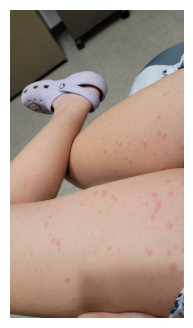

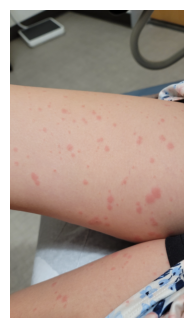

{'Viral Exanthem': 0.5, 'Drug Rash': 0.5}


In [9]:
#@title Display the images for a case (and condition labels, optionally)
import random

import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def display_image(bucket, image_path):
  image = Image.open(io.BytesIO(bucket.blob(image_path).download_as_string()))
  figure_size=4
  f, axarr = plt.subplots(1, 1, figsize = (figure_size, figure_size))
  axarr.imshow(image, cmap='gray')
  axarr.axis('off')
  plt.show()

def display_images_for_case(df, case_id="", print_condition_labels=True):
  # Use a random case if none is provided:
  if case_id:
    matched_df = df[df['case_id'] == case_id]
  else:
    matched_df = df.sample(1)

  image_paths = matched_df[Globals.image_path_columns].values.tolist()[0]
  for path in image_paths:
    if isinstance(path, str):
      display_image(Globals.gcs_bucket, path)
  if print_condition_labels:
    condition_labels = matched_df[[Globals.weighted_skin_condition_label]].values.tolist()[0]
    for label in condition_labels:
      if isinstance(label, str):
        print(label)

# display_images_for_case(Globals.cases_and_labels_df, "-1000600354148496558")
display_images_for_case(Globals.cases_and_labels_df)


In [10]:
#@title Print metadata stats
def print_metadata_stats(df: pd.DataFrame) -> None:
  print(f'Num cases: {len(df)}')

  # Number of cases with 1, 2, or 3 images
  image_1_cnt = df["image_1_path"].count()
  image_2_cnt = df["image_2_path"].count()
  image_3_cnt = df["image_3_path"].count()
  print(f'Num cases with image_1_path set: {image_1_cnt}')
  print(f'Num cases with image_2_path set: {image_2_cnt}')
  print(f'Num cases with image_3_path set: {image_3_cnt}')
  print(f'Total images: {image_1_cnt + image_2_cnt + image_3_cnt}')

  # Sex at birth:
  print('\nSelf-reported Sex at Birth:')
  sab = collections.Counter(df['sex_at_birth'].dropna())
  total = sum(sab.values())
  for k in sorted(sab):
    print(f'  {k} {sab[k]} ({100.0*sab[k]/total:.1f}%)')

  # FST distribution:
  print('\nSelf-reported Fitzpatrick Skin Type:')
  fst = collections.Counter(df['fitzpatrick_skin_type'].dropna())
  total = sum(fst.values())
  for k in sorted(fst):
    print(f'  {k} {fst[k]} ({100.0*fst[k]/total:.1f}%)')


print_metadata_stats(Globals.cases_and_labels_df)

Num cases: 5033
Num cases with image_1_path set: 5033
Num cases with image_2_path set: 3085
Num cases with image_3_path set: 2289
Total images: 10407

Self-reported Sex at Birth:
  FEMALE 1666 (33.1%)
  MALE 807 (16.0%)
  OTHER_OR_UNSPECIFIED 2559 (50.9%)

Self-reported Fitzpatrick Skin Type:
  FST1 188 (7.5%)
  FST2 542 (21.7%)
  FST3 661 (26.4%)
  FST4 427 (17.1%)
  FST5 214 (8.5%)
  FST6 143 (5.7%)
  NONE_IDENTIFIED 328 (13.1%)


In [11]:
#@title Add combined_race_ethnicity column

def merge_race_ethnicity_columns(row):
  combined = []
  for col in row.keys():
    if col.startswith("race_ethnicity_") and row[col] == 'YES':
      combined.append(col[len("race_ethnicity_"):])
  return ",".join(combined)

Globals.cases_and_labels_df["combined_race_ethnicity"] = Globals.cases_and_labels_df.apply(merge_race_ethnicity_columns, axis=1)
Globals.cases_and_labels_df[["case_id", "combined_race_ethnicity"]]

case_id            combined_race_ethnicity
0     -1000600354148496558                                   
1     -1002039107727665188                                   
2     -1003358831658393077  hispanic_latino_or_spanish_origin
3     -1003826561155964328                                   
4     -1003844406100696311                              white
...                    ...                                ...
5028    973759811984683137       two_or_more_after_mitigation
5029    973872028150293734                                   
5030    983265958160210646          black_or_african_american
5031    995820220956352730       two_or_more_after_mitigation
5032    998890198757718998   american_indian_or_alaska_native

[5033 rows x 2 columns]

In [12]:
#@title Print race/ethnicity distribution

def print_race_ethnicity_dist(df):
  c = collections.Counter(df['combined_race_ethnicity'].dropna())
  total = sum(c.values())
  for k in sorted(c):
    if not k:
      k = 'unspecified'
    print(f'  {k}: {c[k]} ({100.0*c[k]/total:.1f}%)')

print_race_ethnicity_dist(Globals.cases_and_labels_df)

  unspecified: 0 (0.0%)
  american_indian_or_alaska_native: 48 (1.0%)
  american_indian_or_alaska_native,white: 25 (0.5%)
  asian: 85 (1.7%)
  asian,white: 11 (0.2%)
  black_or_african_american: 267 (5.3%)
  black_or_african_american,hispanic_latino_or_spanish_origin: 11 (0.2%)
  black_or_african_american,white: 20 (0.4%)
  hispanic_latino_or_spanish_origin: 224 (4.5%)
  hispanic_latino_or_spanish_origin,white: 55 (1.1%)
  middle_eastern_or_north_african: 7 (0.1%)
  native_hawaiian_or_pacific_islander: 4 (0.1%)
  other_race: 16 (0.3%)
  prefer_not_to_answer: 34 (0.7%)
  two_or_more_after_mitigation: 83 (1.6%)
  white: 1762 (35.0%)


## Important Functions

**Variables**
* df_original: The full, unmodified dataset containing all cases, metadata, and image paths. This is equivalent to Globals.cases_and_labels_df and can be used like a normal pandas DataFrame.
* df_filtered: A working copy of the dataset that you can safely modify, filter, or clean without affecting the original.
* image_dir : Use this directory to access images within google cloud


**Functions**
* read_image_from_gcs(gcs_path)
  - Downloads and decodes an image directly from your GCS bucket using the path stored in the dataset (e.g. "dataset/images/12345.png").
* get_all_image_paths()
  - Extracts all unique image paths from the three image columns (image_1_path, image_2_path, image_3_path) in the dataset.
* show_case_images(case_id)
  - Displays all available images for a given case_id directly from GCS.
* convert_to_binary_var(col_name)
  - convert to binary values

In [67]:
df_original = Globals.cases_and_labels_df

In [68]:
df_filtered = df_original.copy()

In [124]:
image_dir = "/content/gcs_mount/dataset/images"

In [65]:
def read_image_from_gcs(gcs_path):
    """Reads and decodes an image from GCS (relative path)."""
    try:
        blob = Globals.gcs_bucket.blob(gcs_path)
        img_bytes = blob.download_as_bytes()
        img_array = np.frombuffer(img_bytes, np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        if img is None:
            return None
        # Convert BGR (OpenCV) → RGB (matplotlib)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img_rgb
    except Exception as e:
        print(f"Failed to read {gcs_path}: {e}")
        return None


In [ ]:
def get_all_image_paths():
    """Flatten all image_1/2/3 columns into a unique list of image paths."""
    image_cols = ['image_1_path', 'image_2_path', 'image_3_path']
    all_paths = (
        Globals.cases_and_labels_df[image_cols]
        .stack()
        .dropna()
        .unique()
        .tolist()
    )
    print(f"📸 Found {len(all_paths)} unique image paths.")
    return all_paths


In [ ]:
def show_case_images(case_id):
    """Display all available images for a given case_id."""
    row = Globals.cases_and_labels_df[Globals.cases_and_labels_df["case_id"] == str(case_id)]
    if row.empty:
        print(f"No case found for ID {case_id}")
        return

    paths = row[['image_1_path', 'image_2_path', 'image_3_path']].dropna(axis=1).values.flatten()
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(paths, 1):
        img = read_image_from_gcs(path)
        plt.subplot(1, len(paths), i)
        plt.imshow(img)
        plt.title(f"{os.path.basename(path)}", fontsize=9)
        plt.axis("off")
    plt.suptitle(f"Case ID: {case_id}", fontsize=12)
    plt.tight_layout()
    plt.show()


In [71]:
def convert_to_binary_var(col_name):
  df_filtered[col_name].replace('YES', 1, inplace = True)
  df_filtered[col_name].fillna(0, inplace = True)
  print(df_filtered[col_name].value_counts())
  print("")


## Skin Condition label information

In [13]:
#@title Print condition distribution

def print_condition_distribution(df, top_n_conditions=50):
  # Any condition that shows up in a label
  condition_ctr = collections.Counter()
  print(f'Distribution of conditions in "{Globals.skin_condition_label}" column:')
  for entry in df[Globals.skin_condition_label].dropna():
    condition_ctr.update(eval(entry))
  for condition, cnt in condition_ctr.most_common()[:top_n_conditions]:
    print(f'  {condition}: {cnt}')
  print(f'Distribution of conditions in "{Globals.weighted_skin_condition_label}" column:')
  weighted_condition_ctr = collections.Counter()
  for entry in df[Globals.weighted_skin_condition_label].dropna():
    weighted_condition_ctr.update(eval(entry).keys())
  for condition, cnt in weighted_condition_ctr.most_common()[:top_n_conditions]:
    print(f'  {condition}: {cnt}')

print_condition_distribution(Globals.cases_and_labels_df)


Distribution of conditions in "dermatologist_skin_condition_on_label_name" column:
  Eczema: 1211
  Allergic Contact Dermatitis: 952
  Insect Bite: 449
  Urticaria: 377
  Psoriasis: 348
  Folliculitis: 297
  Irritant Contact Dermatitis: 254
  Tinea: 232
  Herpes Zoster: 157
  Drug Rash: 156
  Herpes Simplex: 152
  Impetigo: 124
  Acute dermatitis, NOS: 124
  Hypersensitivity: 115
  Acne: 109
  Pigmented purpuric eruption: 108
  Leukocytoclastic Vasculitis: 105
  Lichen planus/lichenoid eruption: 94
  Pityriasis rosea: 89
  Viral Exanthem: 87
  Lichen Simplex Chronicus: 85
  Stasis Dermatitis: 83
  Keratosis pilaris: 72
  CD - Contact dermatitis: 70
  Scabies: 68
  Tinea Versicolor: 68
  Granuloma annulare: 65
  Molluscum Contagiosum: 64
  Rosacea: 57
  Abrasion, scrape, or scab: 51
  O/E - ecchymoses present: 51
  Seborrheic Dermatitis: 50
  Acute and chronic dermatitis: 47
  Photodermatitis: 45
  Cellulitis: 45
  Abscess: 43
  Verruca vulgaris: 42
  SCC/SCCIS: 38
  Purpura: 38
  Inter

In [14]:
#@title Print column names
print(Globals.cases_and_labels_df.columns)

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

## Display distributions of self-reported condition info

Distribution data: {'arm': 1707, 'leg': 1694, 'torso_front': 795, 'head_or_neck': 737, 'torso_back': 652, 'other': 543, 'back_of_hand': 521, 'foot_top_or_side': 415, 'buttocks': 391, 'genitalia_or_groin': 222, 'palm': 215, 'foot_sole': 104}


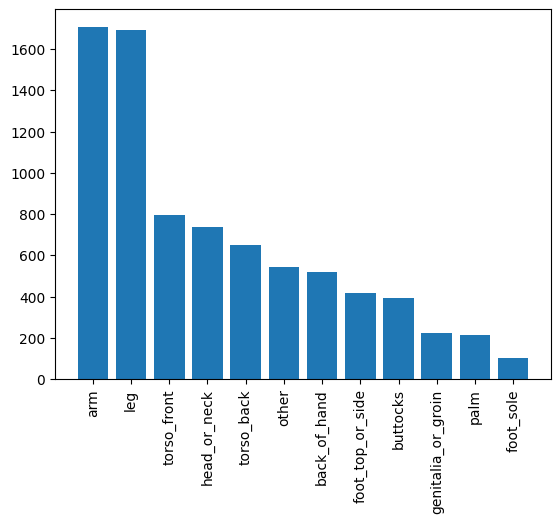

In [ ]:
#@title Display body part distribution

def get_distribution_columns(df, prefix):
  cols = [c for c in df.columns if c.startswith(prefix)]
  dist = collections.Counter()
  for c in cols:
    name = c[len(prefix):]
    val = sum(df[c] == "YES")
    dist[name] = val
  return dist

def get_distribution_and_display(df, prefix):
  ctr = get_distribution_columns(df, prefix)
  dist = dict(ctr.most_common())
  print(f'Distribution data: {dist}')
  names = list(dist.keys())
  counts = list(dist.values())
  plt.bar(names, counts)
  plt.xticks(rotation=90)  # Rotate labels by 90 degrees
  plt.show()

# Distribution data: {'arm': 1707, 'leg': 1694, 'torso_front': 795, 'head_or_neck': 737, 'torso_back': 652, 'other': 543, 'back_of_hand': 521, 'foot_top_or_side': 415, 'buttocks': 391, 'genitalia_or_groin': 222, 'palm': 215, 'foot_sole': 104}
get_distribution_and_display(Globals.cases_and_labels_df, "body_parts_")


Distribution data: {'raised_or_bumpy': 2915, 'rough_or_flaky': 1032, 'flat': 822, 'fluid_filled': 629}


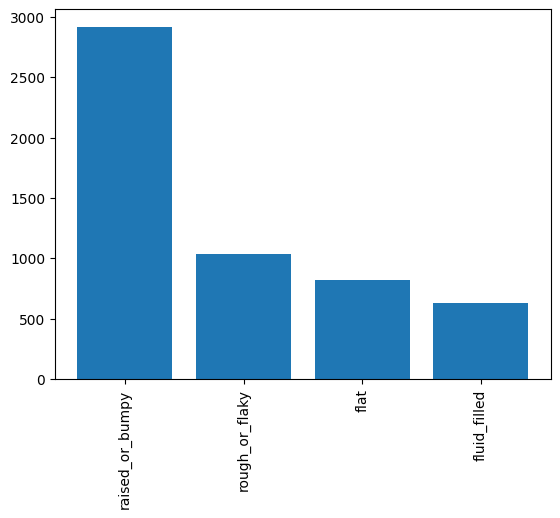

In [ ]:
#@title Display texture distribution
get_distribution_and_display(Globals.cases_and_labels_df, "textures_")

Distribution data: {'itching': 2712, 'bothersome_appearance': 1530, 'increasing_size': 1013, 'burning': 988, 'pain': 734, 'darkening': 385, 'no_relevant_experience': 308, 'bleeding': 225}


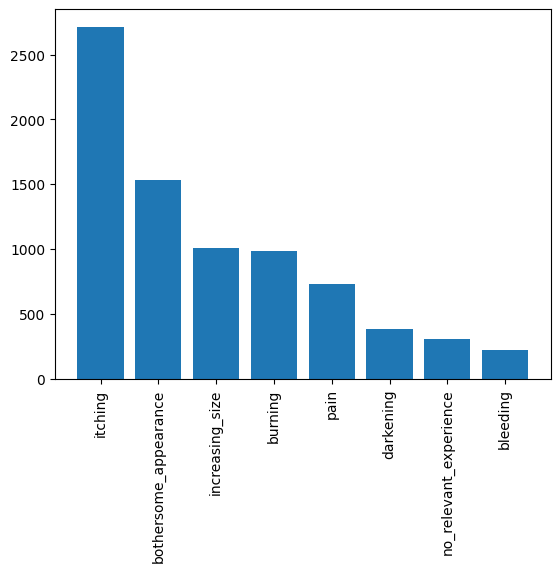

In [ ]:
#@title Display condition symptom dist
get_distribution_and_display(Globals.cases_and_labels_df, "condition_symptoms_")

Distribution data: {'no_relevant_symptoms': 2841, 'fatigue': 415, 'joint_pain': 300, 'shortness_of_breath': 139, 'chills': 120, 'mouth_sores': 96, 'fever': 90}


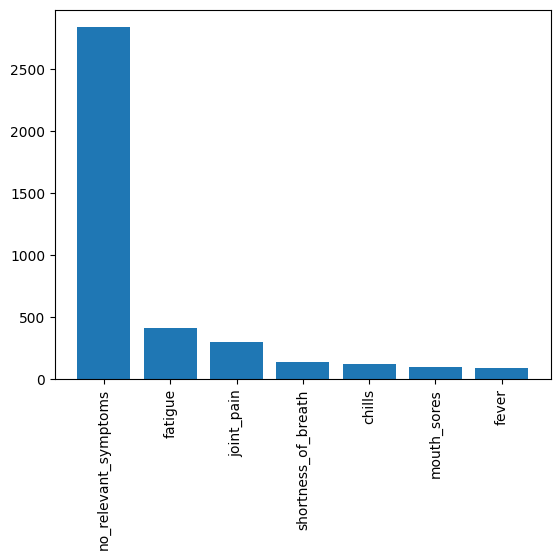

In [ ]:
#@title Display other symptoms distribution
get_distribution_and_display(Globals.cases_and_labels_df, "other_symptoms_")

## Feature Cleaning, Preprocessing, and Exploration

In [94]:
# Checking the null values in case_id
print(df_filtered['case_id'].isnull().sum())
# 0 Null/NaN values

# Checking the count of rows in dataset
print(df_filtered['case_id'].count())

print(df_filtered.shape)

0
5030
(5030, 74)


In [95]:
# Age Group
# Unknown ages are already accounted for by the AGE_UNKNOWN age_group value.
# No handling of missing values for this column/feature.
print(df_filtered['age_group'].count())
df_filtered['age_group'].value_counts()

# Most of the ages in the dataset are unknown.
# Ignoring the unknown ages group, majority of the known ages are young adults (Age 18 to 29).
# Less representation in dataset for elders (ages 60 to 79) results in fewer skin condition images of elders.

5029


age_group
AGE_UNKNOWN     2861
AGE_18_TO_29     769
AGE_40_TO_49     435
AGE_30_TO_39     422
AGE_50_TO_59     322
AGE_60_TO_69     165
AGE_70_TO_79      55
Name: count, dtype: int64

In [96]:
# Sex at Birth
print(df_filtered['sex_at_birth'].count())
df_filtered['sex_at_birth'].value_counts()

# Most sex at birth values are other or unspecified.
# Females at birth have greater representation in dataset than males at birth.

5029


sex_at_birth
OTHER_OR_UNSPECIFIED    2557
FEMALE                  1665
MALE                     807
Name: count, dtype: int64

In [97]:
# Fitzpatrick Skin Type
print(df_filtered['fitzpatrick_skin_type'].count())
df_filtered['fitzpatrick_skin_type'].value_counts()

# Significiant amount of missing values for this column. NaN values will become the value 'NONE_IDENTIFIED'.

5030


fitzpatrick_skin_type
NONE_IDENTIFIED    2857
FST3                660
FST2                542
FST4                427
FST5                214
FST1                188
FST6                142
Name: count, dtype: int64

In [98]:
df_filtered['fitzpatrick_skin_type'].fillna('NONE_IDENTIFIED', inplace = True)
print(df_filtered['fitzpatrick_skin_type'].count())
df_filtered['fitzpatrick_skin_type'].value_counts()

5030


fitzpatrick_skin_type
NONE_IDENTIFIED    2857
FST3                660
FST2                542
FST4                427
FST5                214
FST1                188
FST6                142
Name: count, dtype: int64

In [99]:
print(df_filtered['dermatologist_fitzpatrick_skin_type_label_1'].count())
print(df_filtered['dermatologist_fitzpatrick_skin_type_label_1'].value_counts())
print(" ")

print(df_filtered['dermatologist_fitzpatrick_skin_type_label_2'].count())
print(df_filtered['dermatologist_fitzpatrick_skin_type_label_2'].value_counts())
print(" ")

print(df_filtered['dermatologist_fitzpatrick_skin_type_label_3'].count())
print(df_filtered['dermatologist_fitzpatrick_skin_type_label_3'].value_counts())

# What does the 0 indicate? No image at that image path? Or no FST score identified for an image?

4299
dermatologist_fitzpatrick_skin_type_label_1
FST2    1432
FST3    1331
FST4     718
FST1     390
FST5     359
FST6      69
Name: count, dtype: int64
 
633
dermatologist_fitzpatrick_skin_type_label_2
FST2    243
FST3    172
FST4    119
FST5     51
FST1     42
FST6      6
Name: count, dtype: int64
 
630
dermatologist_fitzpatrick_skin_type_label_3
FST2    234
FST3    190
FST4    119
FST5     57
FST1     30
Name: count, dtype: int64


In [100]:
print(df_filtered['monk_skin_tone_label_india'].count())
print(df_filtered['monk_skin_tone_label_india'].value_counts())

# Q: Are the monk scale numbers 0-indexed? Does monk score of 0 mean monk score of 1 or does it mean no monk score?

5016
monk_skin_tone_label_india
2.0    2425
3.0    1591
4.0     521
1.0     187
5.0     177
6.0      63
7.0      35
8.0      14
9.0       3
Name: count, dtype: int64


In [101]:
print(df_filtered['monk_skin_tone_label_us'].count())
print(df_filtered['monk_skin_tone_label_us'].value_counts())
# Range is from 0 to 10 -> verify this

5002
monk_skin_tone_label_us
2.0     1658
3.0     1265
4.0      687
1.0      577
5.0      360
6.0      248
7.0      137
8.0       57
9.0       11
10.0       2
Name: count, dtype: int64


In [102]:
print(df_filtered['dermatologist_skin_condition_on_label_name'].count())
print(df_filtered['dermatologist_skin_condition_on_label_name'].value_counts()[:15])

5030
dermatologist_skin_condition_on_label_name
[]                                                                1971
['Eczema']                                                         120
['Urticaria']                                                       81
['Eczema', 'Allergic Contact Dermatitis']                           67
['Allergic Contact Dermatitis', 'Irritant Contact Dermatitis']      60
['Allergic Contact Dermatitis']                                     42
['Folliculitis']                                                    37
['Urticaria', 'Insect Bite', 'Allergic Contact Dermatitis']         36
['Acute dermatitis, NOS']                                           27
['Insect Bite']                                                     27
['Tinea', 'Psoriasis', 'Eczema']                                    23
['Urticaria', 'Allergic Contact Dermatitis']                        22
['Psoriasis', 'Eczema']                                             21
['O/E - ecchymoses present'] 

In [103]:
print(df_filtered['dermatologist_skin_condition_confidence'].count())
print(df_filtered['dermatologist_skin_condition_confidence'].value_counts()[:15])
# Overall high confidence in skin condition image scoring by dermatologists (lots of 5 values)

5030
dermatologist_skin_condition_confidence
[]           1971
[5]           311
[4]           208
[2, 2, 2]     178
[2, 2]        176
[1, 1, 1]     170
[4, 2]        112
[3]           103
[2, 4]        100
[1, 1]         63
[3, 2]         45
[1, 5, 1]      40
[5, 1, 1]      38
[2]            34
[2, 3]         33
Name: count, dtype: int64


In [104]:
print(df_filtered['race_ethnicity_american_indian_or_alaska_native'].count())
print(df_filtered['race_ethnicity_american_indian_or_alaska_native'].value_counts())

# Convert these type of columns (Yes vs. NaN values) to binary variable columns.
# 1 -> Yes, 0 -> No

5030
race_ethnicity_american_indian_or_alaska_native
0.0    4957
1.0      73
Name: count, dtype: int64


In [105]:
df_filtered['race_ethnicity_american_indian_or_alaska_native'].replace('YES', 1, inplace = True)
print(df_filtered['race_ethnicity_american_indian_or_alaska_native'].value_counts())

race_ethnicity_american_indian_or_alaska_native
0.0    4957
1.0      73
Name: count, dtype: int64


In [106]:
df_filtered['race_ethnicity_american_indian_or_alaska_native'].fillna(0, inplace = True)
print(df_filtered['race_ethnicity_american_indian_or_alaska_native'].value_counts())

race_ethnicity_american_indian_or_alaska_native
0.0    4957
1.0      73
Name: count, dtype: int64


In [107]:
race_ethnicity_cols_list = ['race_ethnicity_american_indian_or_alaska_native', 'race_ethnicity_asian', 'race_ethnicity_black_or_african_american', 'race_ethnicity_hispanic_latino_or_spanish_origin', 'race_ethnicity_middle_eastern_or_north_african', 'race_ethnicity_native_hawaiian_or_pacific_islander', 'race_ethnicity_white', 'race_ethnicity_other_race', 'race_ethnicity_prefer_not_to_answer', 'race_ethnicity_two_or_more_after_mitigation']

for col in race_ethnicity_cols_list:
  convert_to_binary_var(col)

race_ethnicity_american_indian_or_alaska_native
0.0    4957
1.0      73
Name: count, dtype: int64

race_ethnicity_asian
0.0    4934
1.0      96
Name: count, dtype: int64

race_ethnicity_black_or_african_american
0.0    4732
1.0     298
Name: count, dtype: int64

race_ethnicity_hispanic_latino_or_spanish_origin
0.0    4740
1.0     290
Name: count, dtype: int64

race_ethnicity_middle_eastern_or_north_african
0.0    5023
1.0       7
Name: count, dtype: int64

race_ethnicity_native_hawaiian_or_pacific_islander
0.0    5026
1.0       4
Name: count, dtype: int64

race_ethnicity_white
0.0    3157
1.0    1873
Name: count, dtype: int64

race_ethnicity_other_race
0.0    5015
1.0      15
Name: count, dtype: int64

race_ethnicity_prefer_not_to_answer
0.0    4996
1.0      34
Name: count, dtype: int64

race_ethnicity_two_or_more_after_mitigation
0.0    4948
1.0      82
Name: count, dtype: int64



In [108]:
sum_race_count = 0
for col in race_ethnicity_cols_list:
  value_counts = df_filtered[col].value_counts()
  sum_race_count += value_counts.get(1.0, 0)
print(sum_race_count)

# Only 479 responses regarding race ethnicity.
# Q: should there be a column for 'race_ethnicity_no_response' if a row did not respont to any of the existing race choices?
# Update: The above question was handled in the combined_race column by adding a NO_RESPONSE column.

73


In [109]:
# Texture columns
texture_cols_list = ['textures_raised_or_bumpy', 'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled']

for col in texture_cols_list:
  convert_to_binary_var(col)

sum_texture_count = 0
for col in texture_cols_list:
  value_counts = df_filtered[col].value_counts()
  sum_texture_count += value_counts.get(1.0, 0)
print(sum_texture_count)
# Multiple textures selected for some individuals, hence why sum of texture responses are higher than number of individuals

textures_raised_or_bumpy
1.0    2914
0.0    2116
Name: count, dtype: int64

textures_flat
0.0    4208
1.0     822
Name: count, dtype: int64

textures_rough_or_flaky
0.0    4000
1.0    1030
Name: count, dtype: int64

textures_fluid_filled
0.0    4401
1.0     629
Name: count, dtype: int64

0


In [110]:
# Body part columns
body_parts_col_start = df_original.columns.get_loc('body_parts_head_or_neck')
body_parts_col_end = df_original.columns.get_loc('body_parts_other')
body_parts_cols_list = df_filtered.iloc[:, body_parts_col_start:body_parts_col_end + 1 ]

for col in body_parts_cols_list:
  convert_to_binary_var(col)

sum_body_parts_count = 0
for col in body_parts_cols_list:
  value_counts = df_filtered[col].value_counts()
  sum_body_parts_count += value_counts.get(1.0, 0)
print(sum_body_parts_count)
# Multiple body parts selected for some individuals, hence why sum of body part responses are higher than number of individuals

body_parts_head_or_neck
0.0    4295
1.0     735
Name: count, dtype: int64

body_parts_arm
0.0    3324
1.0    1706
Name: count, dtype: int64

body_parts_palm
0.0    4815
1.0     215
Name: count, dtype: int64

body_parts_back_of_hand
0.0    4509
1.0     521
Name: count, dtype: int64

body_parts_torso_front
0.0    4235
1.0     795
Name: count, dtype: int64

body_parts_torso_back
0.0    4378
1.0     652
Name: count, dtype: int64

body_parts_genitalia_or_groin
0.0    4808
1.0     222
Name: count, dtype: int64

body_parts_buttocks
0.0    4639
1.0     391
Name: count, dtype: int64

body_parts_leg
0.0    3336
1.0    1694
Name: count, dtype: int64

body_parts_foot_top_or_side
0.0    4615
1.0     415
Name: count, dtype: int64

body_parts_foot_sole
0.0    4926
1.0     104
Name: count, dtype: int64

body_parts_other
0.0    4488
1.0     542
Name: count, dtype: int64

0


In [111]:
# symptom columns
symptoms_col_start = df_original.columns.get_loc('condition_symptoms_bothersome_appearance')
symptoms_col_end = df_original.columns.get_loc('other_symptoms_no_relevant_symptoms')
symptoms_cols_list = df_filtered.iloc[:, symptoms_col_start:symptoms_col_end + 1 ]

for col in symptoms_cols_list:
  convert_to_binary_var(col)

sum_symptoms_count = 0
for col in symptoms_cols_list:
  value_counts = df_filtered[col].value_counts()
  sum_symptoms_count += value_counts.get(1.0, 0)
print(sum_symptoms_count)
# Multiple symptoms selected for some individuals, hence why sum of body part responses are higher than number of individuals

condition_symptoms_bothersome_appearance
0.0    3502
1.0    1528
Name: count, dtype: int64

condition_symptoms_bleeding
0.0    4805
1.0     225
Name: count, dtype: int64

condition_symptoms_increasing_size
0.0    4018
1.0    1012
Name: count, dtype: int64

condition_symptoms_darkening
0.0    4645
1.0     385
Name: count, dtype: int64

condition_symptoms_itching
1.0    2711
0.0    2319
Name: count, dtype: int64

condition_symptoms_burning
0.0    4044
1.0     986
Name: count, dtype: int64

condition_symptoms_pain
0.0    4297
1.0     733
Name: count, dtype: int64

condition_symptoms_no_relevant_experience
0.0    4723
1.0     307
Name: count, dtype: int64

other_symptoms_fever
0.0    4940
1.0      90
Name: count, dtype: int64

other_symptoms_chills
0.0    4910
1.0     120
Name: count, dtype: int64

other_symptoms_fatigue
0.0    4615
1.0     415
Name: count, dtype: int64

other_symptoms_joint_pain
0.0    4730
1.0     300
Name: count, dtype: int64

other_symptoms_mouth_sores
0.0    4934
1.0 

In [112]:
print(df_filtered['related_category'].count())
print(df_filtered['related_category'].value_counts())

# Fewer responses than # of individuals, create 'NO_RESPONSE' category
print(" ")
df_filtered['related_category'].fillna("NO_RESPONSE", inplace=True)

print(df_filtered['related_category'].count())
print(df_filtered['related_category'].value_counts())

5030
related_category
RASH                       2874
NO_RESPONSE                1253
OTHER_ISSUE_DESCRIPTION     414
LOOKS_HEALTHY               290
ACNE                         74
GROWTH_OR_MOLE               45
PIGMENTARY_PROBLEM           37
NAIL_PROBLEM                 20
OTHER_HAIR_PROBLEM           12
HAIR_LOSS                    11
Name: count, dtype: int64
 
5030
related_category
RASH                       2874
NO_RESPONSE                1253
OTHER_ISSUE_DESCRIPTION     414
LOOKS_HEALTHY               290
ACNE                         74
GROWTH_OR_MOLE               45
PIGMENTARY_PROBLEM           37
NAIL_PROBLEM                 20
OTHER_HAIR_PROBLEM           12
HAIR_LOSS                    11
Name: count, dtype: int64


In [113]:
print(df_filtered['condition_duration'].count())
print(df_filtered['condition_duration'].value_counts())

# Fewer responses than # of individuals, create 'NO_RESPONSE' category
print(" ")
df_filtered['condition_duration'].fillna("NO_RESPONSE", inplace=True)

print(df_filtered['condition_duration'].count())
print(df_filtered['condition_duration'].value_counts())

4033
condition_duration
LESS_THAN_ONE_WEEK        1384
ONE_TO_FOUR_WEEKS          959
ONE_DAY                    784
ONE_TO_THREE_MONTHS        318
THREE_TO_TWELVE_MONTHS     237
MORE_THAN_ONE_YEAR         201
MORE_THAN_FIVE_YEARS        91
UNKNOWN                     39
SINCE_CHILDHOOD             20
Name: count, dtype: int64
 
5030
condition_duration
LESS_THAN_ONE_WEEK        1384
NO_RESPONSE                997
ONE_TO_FOUR_WEEKS          959
ONE_DAY                    784
ONE_TO_THREE_MONTHS        318
THREE_TO_TWELVE_MONTHS     237
MORE_THAN_ONE_YEAR         201
MORE_THAN_FIVE_YEARS        91
UNKNOWN                     39
SINCE_CHILDHOOD             20
Name: count, dtype: int64


/tmp/ipython-input-4034279181.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['condition_duration'].fillna("NO_RESPONSE", inplace=True)


In [114]:
print(df_filtered['image_1_shot_type'].count())
print(df_filtered['image_1_shot_type'].value_counts())

5030
image_1_shot_type
CLOSE_UP       3080
AT_AN_ANGLE    1138
AT_DISTANCE     812
Name: count, dtype: int64


In [115]:
print(df_filtered['image_2_shot_type'].count())
print(df_filtered['image_2_shot_type'].value_counts())
print(" ")
# Images dont exist -> value for shot type is not applicable
df_filtered['image_2_shot_type'].fillna("N/A", inplace=True)
print(df_filtered['image_2_shot_type'].count())
print(df_filtered['image_2_shot_type'].value_counts())

3082
image_2_shot_type
CLOSE_UP       1200
AT_AN_ANGLE    1109
AT_DISTANCE     773
Name: count, dtype: int64
 
5030
image_2_shot_type
N/A            1948
CLOSE_UP       1200
AT_AN_ANGLE    1109
AT_DISTANCE     773
Name: count, dtype: int64


/tmp/ipython-input-1910787688.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['image_2_shot_type'].fillna("N/A", inplace=True)


In [116]:
print(df_filtered['image_3_shot_type'].count())
print(df_filtered['image_3_shot_type'].value_counts())
print(" ")
# Images dont exist -> value for shot type is not applicable
df_filtered['image_3_shot_type'].fillna("N/A", inplace=True)
print(df_filtered['image_3_shot_type'].count())
print(df_filtered['image_3_shot_type'].value_counts())

2289
image_3_shot_type
AT_DISTANCE    778
AT_AN_ANGLE    765
CLOSE_UP       746
Name: count, dtype: int64
 
5030
image_3_shot_type
N/A            2741
AT_DISTANCE     778
AT_AN_ANGLE     765
CLOSE_UP        746
Name: count, dtype: int64


/tmp/ipython-input-4079439327.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['image_3_shot_type'].fillna("N/A", inplace=True)


In [117]:
print(df_filtered['combined_race'].count())
print(df_filtered['combined_race'].value_counts())
# Fewer responses than # of individuals, create 'NO_RESPONSE' category
print(" ")
df_filtered['combined_race'].fillna("NO_RESPONSE", inplace=True)

print(df_filtered['combined_race'].count())
print(df_filtered['combined_race'].value_counts())

2650
combined_race
WHITE                                                          1762
BLACK_OR_AFRICAN_AMERICAN                                       267
HISPANIC_LATINO_OR_SPANISH_ORIGIN                               224
ASIAN                                                            85
TWO_OR_MORE_AFTER_MITIGATION                                     82
HISPANIC_LATINO_OR_SPANISH_ORIGIN,WHITE                          55
AMERICAN_INDIAN_OR_ALASKA_NATIVE                                 48
PREFER_NOT_TO_ANSWER                                             34
AMERICAN_INDIAN_OR_ALASKA_NATIVE,WHITE                           25
BLACK_OR_AFRICAN_AMERICAN,WHITE                                  20
OTHER_RACE                                                       15
ASIAN,WHITE                                                      11
BLACK_OR_AFRICAN_AMERICAN,HISPANIC_LATINO_OR_SPANISH_ORIGIN      11
MIDDLE_EASTERN_OR_NORTH_AFRICAN                                   7
NATIVE_HAWAIIAN_OR_PACIFIC_IS

/tmp/ipython-input-3659410233.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['combined_race'].fillna("NO_RESPONSE", inplace=True)


In [118]:
print(df_filtered['race_ethnicity_two_or_more_after_mitigation'].count())
print(df_filtered['race_ethnicity_two_or_more_after_mitigation'].value_counts())

82
race_ethnicity_two_or_more_after_mitigation
YES    82
Name: count, dtype: int64


/tmp/ipython-input-975958780.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_filtered, x='combined_race', order=df_filtered['combined_race'].value_counts().index, palette='flare')


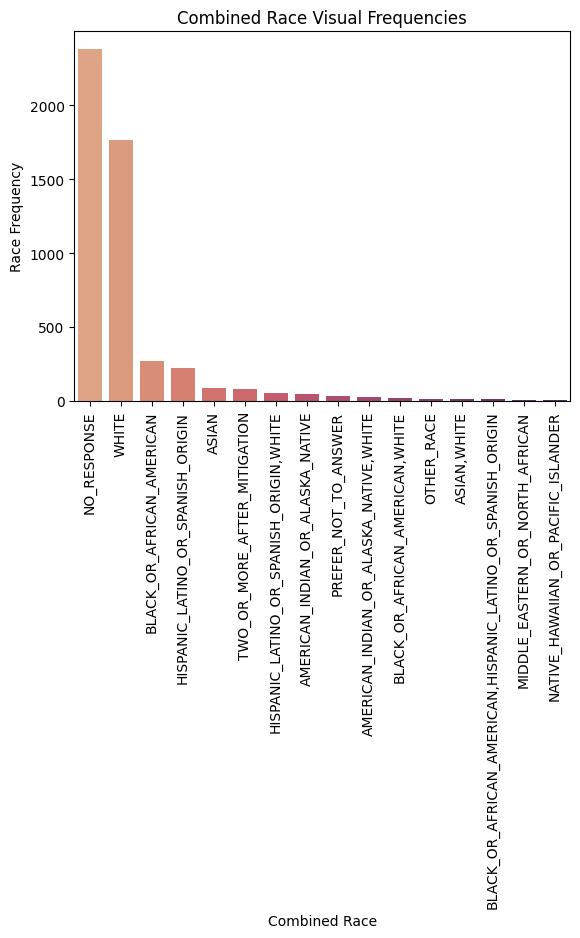

In [122]:
sns.countplot(df_filtered, x='combined_race', order=df_filtered['combined_race'].value_counts().index, palette='flare')
plt.title("Combined Race Visual Frequencies")
plt.xlabel("Combined Race")
plt.ylabel("Race Frequency")
plt.xticks(rotation=90)
plt.show()

## Image Analysis

### Stage 1: Image Quality Analysis

In [15]:
from google.cloud import storage
# List all images in dataset/images/
all_images = []
for blob in Globals.gcs_bucket.list_blobs(prefix=Globals.gcs_images_dir):
    if blob.name.endswith((".jpg",".jpeg",".png")):
        all_images.append(blob.name)

#### Scan images for common issues using clean vision library

In [ ]:
# To import entire dataset locally (HAS NOT BEEN DONE YET OFFICIALLY)
'''
# Set destination directory
save_dir = "/content/drive/My Drive/BTT Skinterest 2A/Dataset/Original_Google_dataset_images"
os.makedirs(save_dir, exist_ok=True)

# Download all images from GCS to local drive
for path in tqdm(all_images, desc="Downloading images"):
    try:
        blob = Globals.gcs_bucket.blob(path)
        filename = os.path.basename(path)  # keep only the image name
        local_path = os.path.join(save_dir, filename)
        blob.download_to_filename(local_path)
    except Exception as e:
        print(f"Error downloading {path}: {e}")

print(f"\n All images saved to: {save_dir}")
'''

In [ ]:
!pip install cleanvision

In [17]:
!lsb_release -c -s

jammy


In [ ]:
# Clean up any previous bad entries
!rm -f /etc/apt/sources.list.d/gcsfuse.list

# Add the new official gcsfuse repository for Ubuntu 22.04 (Jammy)
!echo "deb [signed-by=/usr/share/keyrings/cloud.google.gpg] https://packages.cloud.google.com/apt gcsfuse-jammy main" | tee /etc/apt/sources.list.d/gcsfuse.list

# Add the Google Cloud public key
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | gpg --dearmor -o /usr/share/keyrings/cloud.google.gpg

# Update and install gcsfuse
!apt-get update
!apt-get install -y gcsfuse

# Create mount directory and mount the bucket
!mkdir -p /content/gcs_mount
!gcsfuse --implicit-dirs dx-scin-public-data /content/gcs_mount


In [33]:
'''
DATA_PATH = "/content/gcs_mount/dataset/images"

#  Initialize CleanVision
imagelab = Imagelab(data_path=DATA_PATH)

#  Run full issue detection
print("Starting CleanVision analysis... please wait.")
start = time.time()

# Use all CPU cores and resize images for speed
imagelab.find_issues()

elapsed = (time.time() - start) / 60
print(f"\nCleanVision analysis completed in {elapsed:.2f} minutes.\n")
'''

Reading images from /content/gcs_mount/dataset/images
Starting CleanVision analysis... please wait.
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/10379 [00:00<?, ?it/s]

  0%|          | 0/10379 [00:00<?, ?it/s]

Issue checks completed. 1067 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().

CleanVision analysis completed in 55.86 minutes.



Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | blurry           |          901 |
|  1 | odd_size         |          111 |
|  2 | odd_aspect_ratio |           36 |
|  3 | near_duplicates  |           10 |
|  4 | dark             |            7 |
|  5 | low_information  |            2 |
|  6 | light            |            0 |
|  7 | grayscale        |            0 |
|  8 | exact_duplicates |            0 | 

---------------------- blurry images -----------------------

Number of examples with this issue: 901
Examples representing most severe instances of this issue:



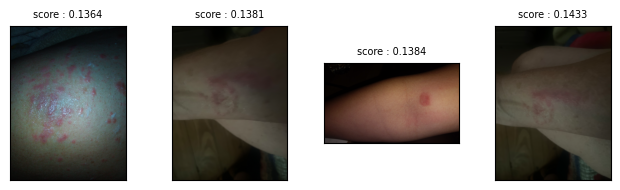

--------------------- odd_size images ----------------------

Number of examples with this issue: 111
Examples representing most severe instances of this issue:



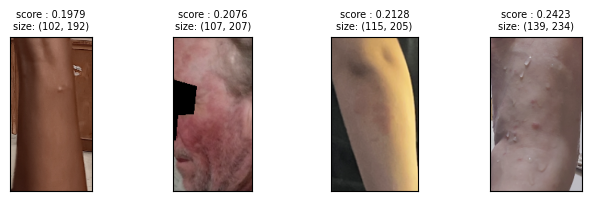

----------------- odd_aspect_ratio images ------------------

Number of examples with this issue: 36
Examples representing most severe instances of this issue:



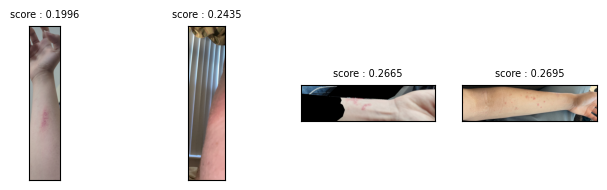

------------------ near_duplicates images ------------------

Number of examples with this issue: 10
Examples representing most severe instances of this issue:

Set: 0


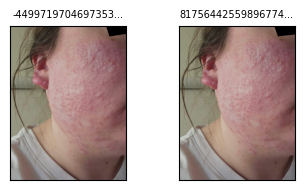

Set: 1


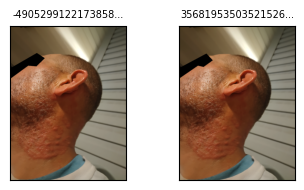

Set: 2


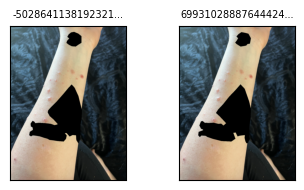

Set: 3


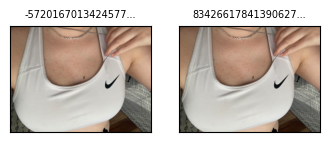

----------------------- dark images ------------------------

Number of examples with this issue: 7
Examples representing most severe instances of this issue:



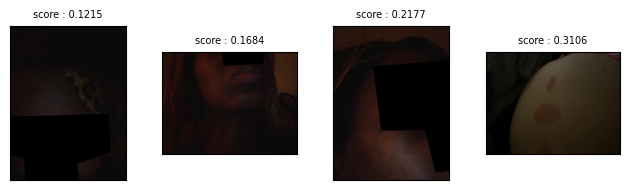

------------------ low_information images ------------------

Number of examples with this issue: 2
Examples representing most severe instances of this issue:



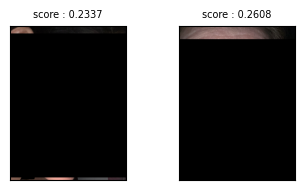

In [41]:
#imagelab.report()

In [42]:
cols = ['image_1_path', 'image_2_path', 'image_3_path']
Globals.cases_and_labels_df[cols].head(5)

image_1_path  \
0  dataset/images/-3205742176803893704.png   
1  dataset/images/-4762289084741430925.png   
2  dataset/images/-4027806997035329030.png   
3  dataset/images/-5332065579713135540.png   
4  dataset/images/-3799298995660217860.png   

                              image_2_path  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3  dataset/images/-6353431708064969797.png   
4  dataset/images/-5881426422999442186.png   

                             image_3_path  
0                                     NaN  
1                                     NaN  
2                                     NaN  
3   dataset/images/742075435141960831.png  
4  dataset/images/5854025080806696361.png

In [69]:
# Problematic images identified by CleanVision
to_drop = [
    "dataset/images/-4593817128438983108.png",
    "dataset/images/-2431769699504014881.png"
]

# Columns that contain image paths
image_cols = ['image_1_path', 'image_2_path', 'image_3_path']

# Build a boolean mask for rows that have any of these images
mask = df_filtered[image_cols].isin(to_drop).any(axis=1)

# Apply filter (keep only rows without those images)
df_filtered = df_filtered[~mask].copy()

print(f"Removed {mask.sum()} rows containing problematic images.")
print(f" Filtered dataset now has {len(df_filtered)} rows.")


Removed 2 rows containing problematic images.
 Filtered dataset now has 5030 rows.


#### **Image Duplicate Detection using Python Library: ImageDedup** <br>
https://github.com/idealo/imagededup

In [ ]:
# Find duplicates using python library ImageDedup
!pip install imagededup

In [127]:
# Convolutional Neural Network method from ImageDedup for identifying duplicate images.
from imagededup.methods import CNN
cnn = CNN()
duplicates = cnn.find_duplicates(image_dir=image_dir, min_similarity_threshold=0.9)
# Print the duplicate groups
for key, value in duplicates.items():
    if value: # Only print if there are duplicates for this image
        print(f"Duplicates for {key}: {value}")

2025-10-15 01:21:18,651: INFO Device set to cuda ..
INFO:imagededup.methods.cnn:Device set to cuda ..
2025-10-15 01:21:18,660: INFO Initialized: mobilenet_v3_small for feature extraction ..
INFO:imagededup.methods.cnn:Initialized: mobilenet_v3_small for feature extraction ..
2025-10-15 01:21:18,662: INFO Start: Image encoding generation
INFO:imagededup.methods.cnn:Start: Image encoding generation


KeyboardInterrupt: 

#### Image analysis

In [46]:
save_dir = "/content/drive/My Drive/BTT_Skinterest_2A/Dataset"
os.makedirs(save_dir, exist_ok=True)


The goal is to assess technical factors such as blur, exposure, contrast, and shadow presence, which primarily depend on luminance (the perceived brightness of pixels) rather than their chromatic (color) components.


**Luminance Histogram**

Converting images to grayscale simplifies this process by collapsing the three color channels (Red, Green, Blue) into a single intensity channel. This reduces computational complexity and eliminates redundant color information that does not significantly affect the measurements of sharpness or exposure.


Blur detection uses edge variance (via the Laplacian operator), which relies on intensity gradients rather than color differences.

Brightness and exposure metrics depend on pixel intensity distributions.

Contrast and shadow evaluations are based on light–dark relationships, independent of hue.

Thus, grayscale provides a cleaner, noise-reduced representation for these low-level quality features, ensuring that color variation does not falsely influence results.


In [ ]:

'''
def evaluate_image(blob):
    """Download one image blob and compute quality features."""
    img_bytes = blob.download_as_bytes()
    # Each byte = 8 bits ; 8 bits per channel allows intensity values from 0–255, which is the standard in most digital image formats (aka matrix format).
    img_array = np.frombuffer(img_bytes, np.uint8)
    # Decodes the compressed JPEG/PNG bytes, and returns a NumPy array representing the image
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # Converts the color image into grayscale to evaluate brightness, blur, and contrast without color difference
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur
    blur = cv2.Laplacian(gray, cv2.CV_64F).var() # converts the image from color (3 channels: Blue, Green, Red) → to grayscale

    # Brightness stats
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist = hist.ravel() / hist.sum()
    mean = (hist * np.arange(256)).sum()
    std = np.sqrt((hist * (np.arange(256)-mean)**2).sum())
    under_exp = hist[:30].sum()
    over_exp = hist[220:].sum()

    # Contrast
    contrast = (gray.max() - gray.min()) / (gray.max() + 1e-6)

    # Shadows
    shadow_pixels = (gray < mean - 1.5*std).sum()
    shadow = shadow_pixels / gray.size

    return blur, mean, std, under_exp, over_exp, contrast, shadow

#evaluate images
results = []

for path in tqdm(all_images):
    blob = Globals.gcs_bucket.blob(path)
    try:
        blur, mean, std, under, over, contrast, shadow = evaluate_image(blob)
        results.append({
            "image_path": path,
            "blur": blur,
            "brightness_mean": mean,
            "brightness_std": std,
            "underexp": under,
            "overexp": over,
            "contrast": contrast,
            "shadow": shadow
        })
    except Exception as e:
        results.append({
            "image_path": path,
            "status": f"error: {e}"
        })

quality_df = pd.DataFrame(results)
save_path = os.path.join(save_dir, "image_quality_report.csv")
quality_df.to_csv(save_path, index=False)
print("Saved report to:", save_path)
quality_df.head()
'''

In [45]:
!pip install opencv-python-headless numpy matplotlib tqdm pandas cupy-cuda12x

In [ ]:
import os, cv2, numpy as np, cupy as cp, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate_image_and_hist_gpu(blob, hist_dir):
    img_bytes = blob.download_as_bytes()
    np_img = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(np_img, cv2.IMREAD_COLOR)

    # --- Upload to GPU ---
    gpu_img = cv2.cuda_GpuMat()
    gpu_img.upload(img)

    # Convert to grayscale on GPU
    gpu_gray = cv2.cuda.cvtColor(gpu_img, cv2.COLOR_BGR2GRAY)

    # Laplacian (blur)
    gpu_lap = cv2.cuda.Laplacian(gpu_gray, cv2.CV_64F)
    blur = float(cp.var(cp.asarray(gpu_lap.download())))

    # Download grayscale back to CPU for histogram & brightness metrics
    gray = gpu_gray.download()
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()

    mean = (hist * np.arange(256)).sum()
    std = np.sqrt((hist * (np.arange(256) - mean) ** 2).sum())
    under_exp = hist[:30].sum()
    over_exp = hist[220:].sum()
    contrast = (gray.max() - gray.min()) / (gray.max() + 1e-6)
    shadow_pixels = (gray < mean - 1.5 * std).sum()
    shadow = shadow_pixels / gray.size

    # --- Save histogram plot ---
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.plot(hist, color='gray')
    plt.xlim([0, 255])
    plt.tight_layout()

    filename = os.path.basename(blob.name)
    hist_path = os.path.join(hist_dir, filename.replace('.png', '_hist.png'))
    plt.savefig(hist_path, bbox_inches='tight')
    plt.close()

    return blur, mean, std, under_exp, over_exp, contrast, shadow, hist_path


To determine exposure, contrast, and shadow an historgram is used.

**A histogram is like a bar graph that tells you how bright or dark your picture is.**

* On the bottom (X-axis), you have brightness:
    * 0 = totally black
    * 255 = totally white
* On the side (Y-axis), you have how many pixels have that brightness.


In the code we first:

1. Looks at every pixel.

2. Figures out how bright that pixel is.

3. Puts that brightness into a bucket (0–255).

4. Counts how many pixels are in each bucket.

In [47]:
save_path = os.path.join(save_dir, "image_quality_report.csv")
quality_df = pd.read_csv(save_path)
print("Loaded", len(quality_df), "rows")
quality_df.head()

Loaded 10379 rows


image_path        blur  brightness_mean  \
0  dataset/images/-1001492676369731180.png   49.800900       125.822289   
1  dataset/images/-1001733364362669777.png  238.390468        74.623044   
2  dataset/images/-1003800477193786941.png   89.631693       128.779480   
3  dataset/images/-1005922060850163675.png    4.172010       102.138025   
4  dataset/images/-1007969568196430462.png    9.460231       147.597770   

   brightness_std  underexp   overexp  contrast    shadow  
0       62.991703  0.152014  0.049442  0.988142  0.162389  
1       29.900723  0.036180  0.000554  1.000000  0.036180  
2       47.623139  0.005774  0.023419  0.980237  0.055794  
3       62.690025  0.179942  0.000000  0.990610  0.010904  
4       40.054561  0.000000  0.002477  0.819608  0.107458

| **Feature**            | **Calculation**                     | **Meaning**             | **Interpretation**                     |
|-------------------------|--------------------------------------|-------------------------|-----------------------------------------|
| **Blur score**         | Variance of Laplacian                | Edge sharpness          | Low = blurry, High = sharp              |
| **Brightness mean**    | Weighted mean of pixel histogram     | Avg light level         | Low = dark, High = bright               |
| **Brightness std**     | Std dev of pixel histogram           | Spread of brightness    | Low = flat, High = strong contrast      |
| **Underexposed ratio** | % of pixels < 30                     | Dark pixel proportion   | High = underexposed                     |
| **Overexposed ratio**  | % of pixels > 220                    | Bright pixel proportion | High = overexposed                      |
| **Contrast ratio**     | (max − min) / max                    | Global contrast level   | Low = washed-out, High = clear contrast |
| **Shadow score**       | % pixels < (mean − 1.5 × std)        | Shadow prevalence       | High = harsh shadows                    |


In [61]:
BRIGHTNESS_THRESHOLD = 35

# Filter images below threshold
low_brightness = quality_df[quality_df["brightness_mean"] < BRIGHTNESS_THRESHOLD].copy()

print(f"Found {len(low_brightness)} low-brightness images (brightness < {BRIGHTNESS_THRESHOLD}).")
low_brightness.head()


Found 25 low-brightness images (brightness < 35).


image_path        blur  brightness_mean  \
157   dataset/images/-1228817739925967571.png  147.946052        28.913105   
559   dataset/images/-1892382246747642071.png   10.112191        33.061405   
2162  dataset/images/-4388927783827168379.png   40.428639        24.474954   
2188  dataset/images/-4420030369319850334.png    8.933521        25.518788   
2314  dataset/images/-4593817128438983108.png   24.394457         7.225324   

      brightness_std  underexp   overexp  contrast    shadow  
157        40.407485  0.635195  0.000085  1.000000  0.000000  
559        19.096216  0.434107  0.000000  1.000000  0.073201  
2162       47.219252  0.783329  0.000000  1.000000  0.000000  
2188       37.088688  0.782494  0.000000  0.994652  0.000000  
2314       26.778409  0.928459  0.000000  1.000000  0.000000

                                    image_path  brightness_mean
7222    dataset/images/4207723573736028617.png         3.000142
2314   dataset/images/-4593817128438983108.png         7.225324
2577   dataset/images/-5011725349239782670.png        10.087398
6148    dataset/images/2463627181124420150.png        16.282287
9581    dataset/images/8036455545054403660.png        16.366034
10218   dataset/images/8998575481244720388.png        17.685991
2884   dataset/images/-5577487989287415054.png        20.770351
9603    dataset/images/8077600272482094664.png        22.724186
5073   dataset/images/-8976765446994754471.png        23.483824
2162   dataset/images/-4388927783827168379.png        24.474954
8421    dataset/images/6123668462268410240.png        24.669304
2188   dataset/images/-4420030369319850334.png        25.518788
5368    dataset/images/1138155103798937122.png        26.869387
6196    dataset/images/2542656689420019332.png        27.165319
5715    dataset/images/16882968380540206

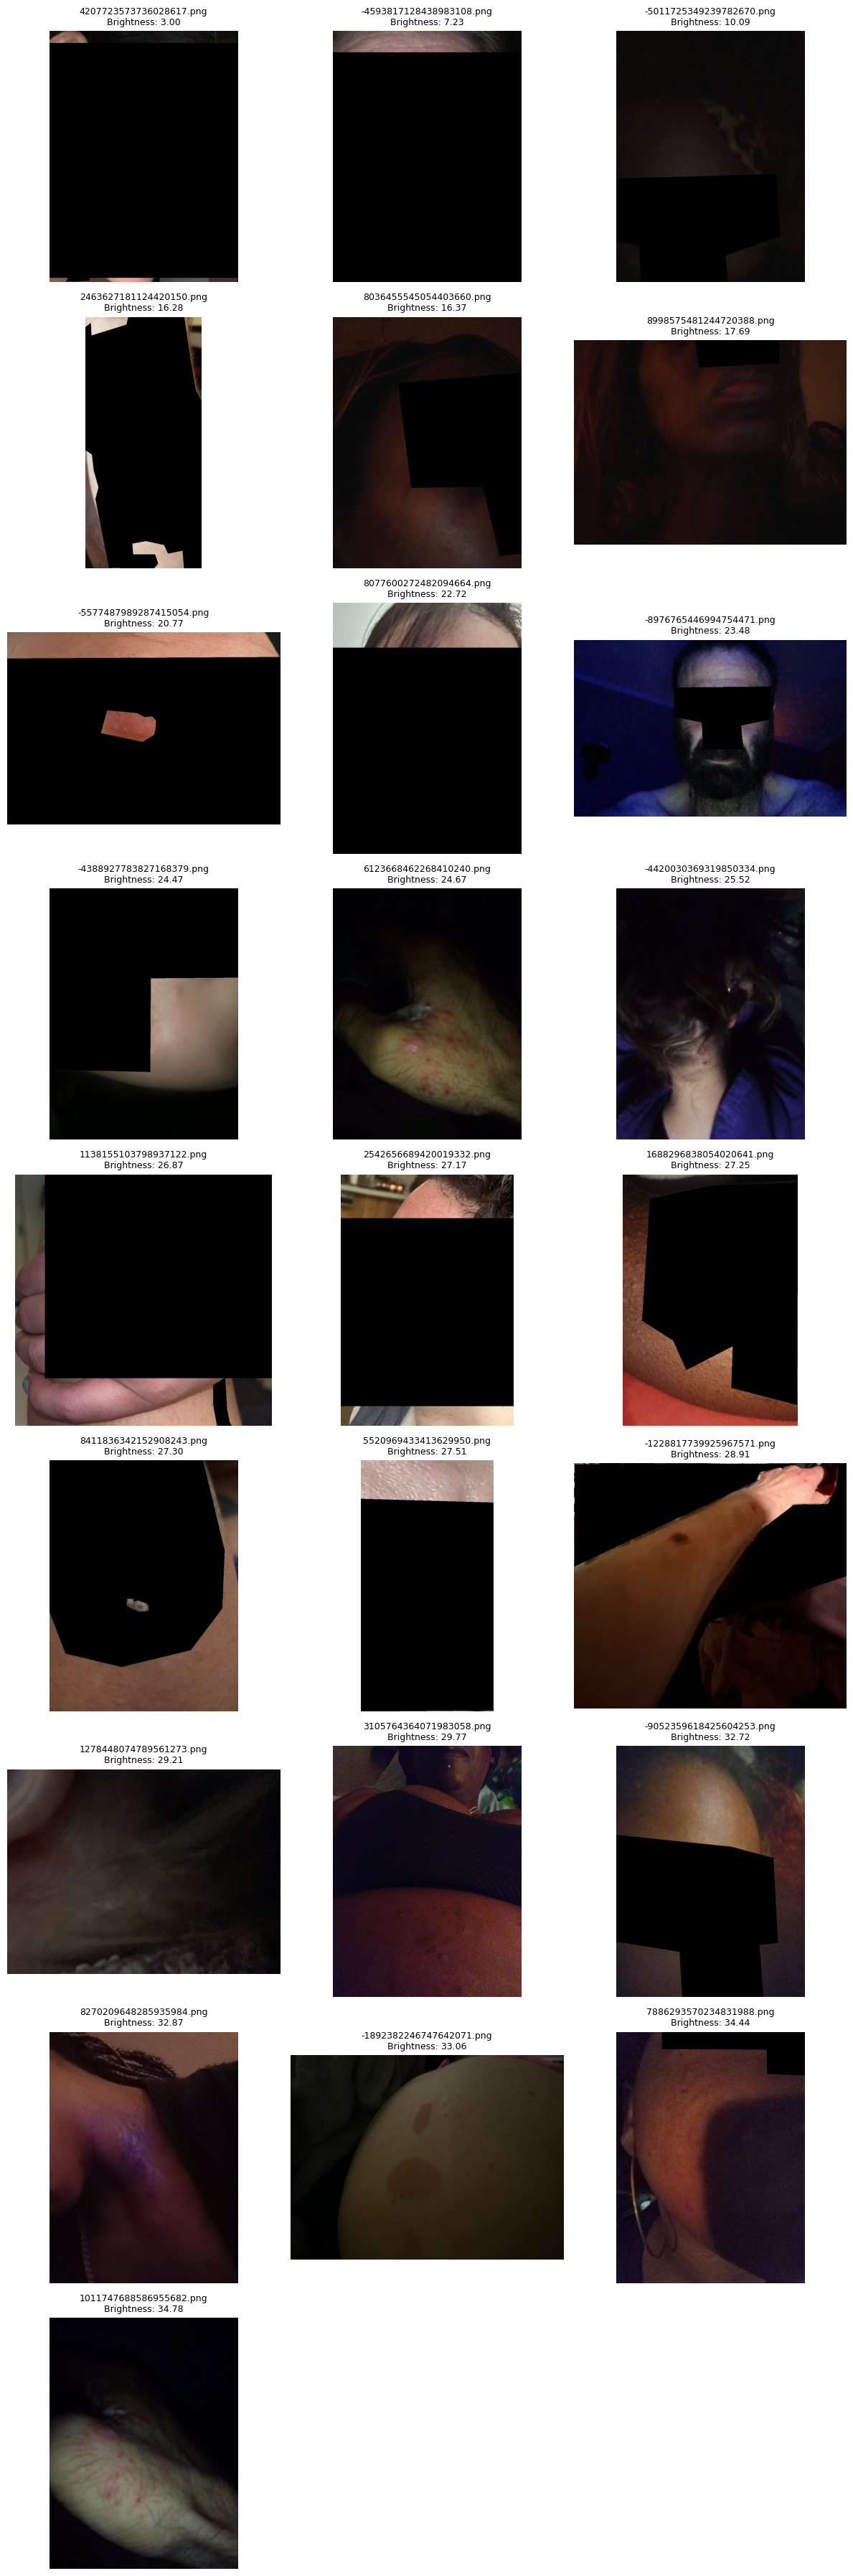

In [62]:
darkest_images = low_brightness.sort_values("brightness_mean", ascending=True).head(25)
print(darkest_images[["image_path", "brightness_mean"]])

n_cols = 3
n_rows = int(np.ceil(len(darkest_images) / n_cols))
plt.figure(figsize=(12, 4 * n_rows))

for idx, row in enumerate(darkest_images.itertuples(), 1):
    gcs_path = row.image_path
    brightness = row.brightness_mean
    img = read_image_from_gcs(gcs_path)

    plt.subplot(n_rows, n_cols, idx)
    if img is not None:
        plt.imshow(img)
        plt.title(f"{os.path.basename(gcs_path)}\nBrightness: {brightness:.2f}", fontsize=9)
    else:
        plt.text(0.5, 0.5, "Unreadable", ha='center', va='center')
    plt.axis("off")

plt.tight_layout()
plt.show()


In [70]:
# Problematic images identified by CleanVision
to_drop_2 = [
    "dataset/images/4207723573736028617.png",
]

mask_2 = df_filtered[image_cols].isin(to_drop_2).any(axis=1)
df_filtered = df_filtered.loc[~mask_2]

print(f"Removed {mask_2.sum()} rows containing problematic images.")
print(f" Filtered dataset now has {len(df_filtered)} rows.")

Removed 1 rows containing problematic images.
 Filtered dataset now has 5030 rows.


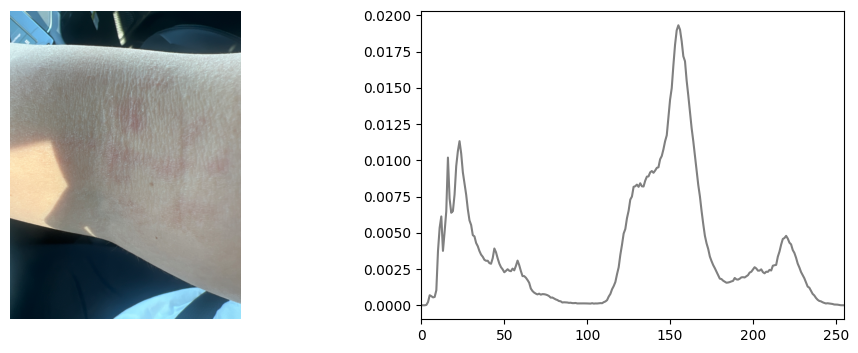

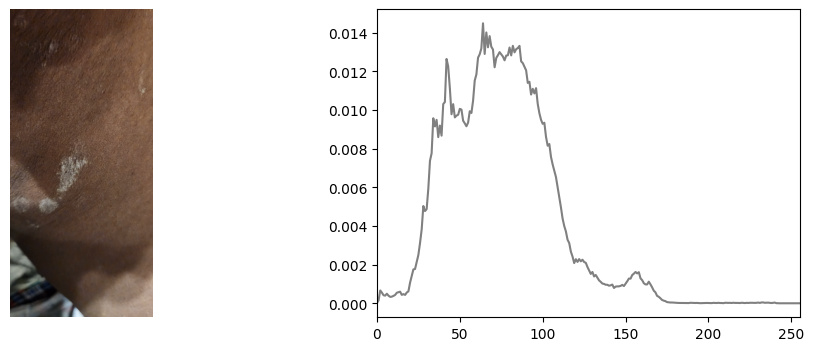

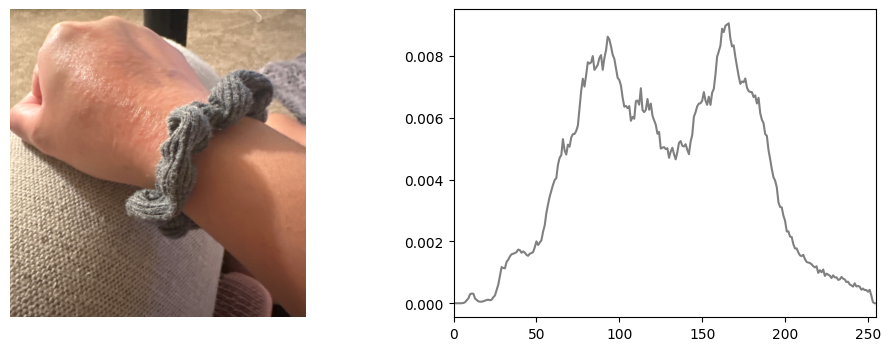

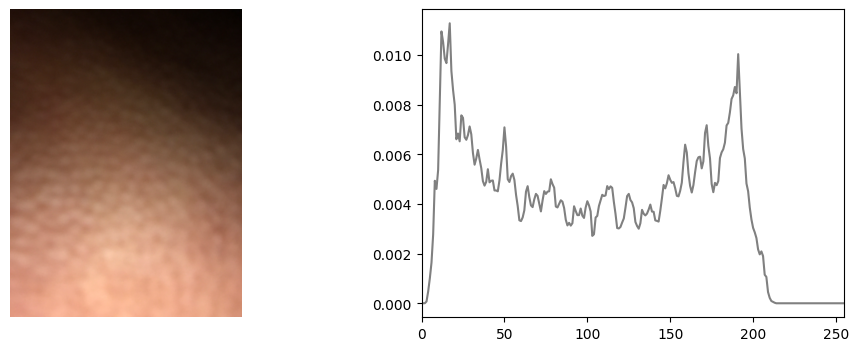

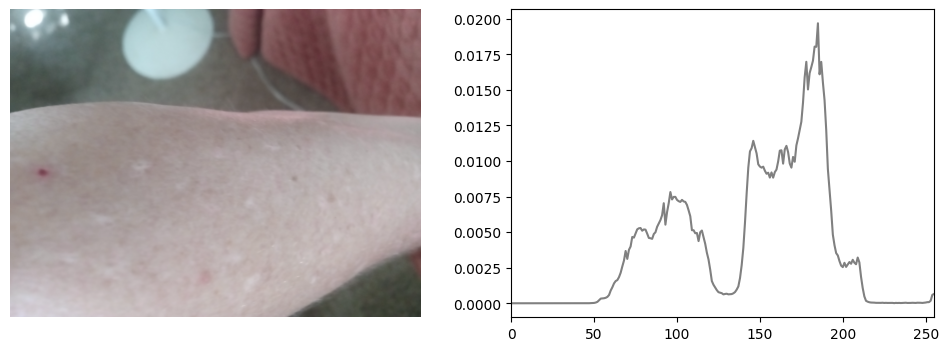

In [64]:
for path in quality_df['image_path'][:5]:
    blob = Globals.gcs_bucket.blob(path)
    img_bytes = blob.download_as_bytes()
    img_array = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0,256])
    hist = hist.ravel() / hist.sum()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.plot(hist, color='gray')
    plt.xlim([0, 255])
    plt.show()


#Resizing Images